This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/main/wallaroo-testing-tutorials/wallaro-assay-builder-tutorial).

## Wallaroo Assay Builder Tutorial

The Model Insights feature lets you monitor how the environment that your model operates within may be changing in ways that affect it's predictions so that you can intervene (retrain) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user preference or behavior. 

The [validation framework](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipeline/#anomaly-testing) performs per inference range checks with count frequency based thresholds for alerts and is ideal for catching many errors in input and output data.

In complement to the validation framework model insights focuses on the differences in the distributions of data in a time based window measured against a baseline for a given pipeline and can detect situations where values are still within the expected range but the distribution has shifted. For example, if your model predicts housing prices you might expect the predictions to be between \\$200,000 and \\$1,000,000 with a distribution centered around \\$400,000. If your model suddenly starts predicting prices centered around \\$250,000 or \\$750,000 the predictions may still be within the expected range but the shift may signal something has changed that should be investigated.

Ideally we'd also monitor the _quality_ of the predictions, **concept drift**. However this can be difficult as true labels are often not available or are severely delayed in practice. That is there may be a signficant lag between the time the prediction is made and the true (sale price) value is observed.

Consequently, model insights uses data drift detection techniques on both inputs and outputs to detect changes in the distributions of the data.

There are many useful statistical tests for calculating the difference between distributions; however, they typically require assumptions about the underlying distributions or confusing and expensive calculations. We've implemented a data drift framework that is easy to understand, fast to compute, runs in an automated fashion and is extensible to many specific use cases.

The methodology currently revolves around calculating the specific percentile-based bins of the baseline distribution and measuring how future distributions fall into these bins. This approach is both visually intuitive and supports an easy to calculate difference score between distributions. Users can tune the scoring mechanism to emphasize different regions of the distribution: for example, you may only care if there is a change in the top 20th percentile of the distribution, compared to the baseline.

You can specify the inputs or outputs that you want to monitor and the data to use for your baselines. You can also specify how often you want to monitor distributions and set parameters to define what constitutes a meaningful change in a distribution for your application. 

Once you've set up a monitoring task, called an assay, comparisons against your baseline are then run automatically on a scheduled basis. You can be notified if the system notices any abnormally different behavior. The framework also allows you to quickly investigate the cause of any unexpected drifts in your predictions.

The rest of this notebook will shows how to create assays to monitor your pipelines.

For full details see the [Wallaroo Assays Management](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

### Resources

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

### Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame


## Steps

* Deploying a sample ML model used to determine house prices based on a set of input parameters.
* Creating an Assay from a set of baseline start and end dates, and an Assay from baseline data from a numpy array.
* Perform an interactive assay run and display statistics about that assay.
* Display results for each assay window in the interactive assay.
* Upload the assay.

### Import Libraries

The first step will be to import our libraries, and set variables used through this tutorial.

In [2]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time



# used for unique connection names

import string
import random

suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))
suffix=''

# used to make a unique workspace
suffix='baseline-examples'

workspace_name = f'assay-demonstration-tutorial{suffix}'
main_pipeline_name = f'assay-demonstration-tutorial'
model_name_control = f'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name=f"house price test{suffix}"

In [3]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name, workspace):
    pipelines = workspace.pipelines()
    pipe_filter = filter(lambda x: x.name() == name, pipelines)
    pipes = list(pipe_filter)
    # we can't have a pipe in the workspace with the same name, so it's always the first
    if pipes:
        pipeline = pipes[0]
    else:
        pipeline = wl.build_pipeline(name)
    return pipeline

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [4]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [5]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

{'name': 'assay-demonstration-tutorialbaseline-examples', 'id': 26, 'archived': False, 'created_by': 'df2b4a6c-b749-466a-95b4-60cf14fc354d', 'created_at': '2024-01-31T18:37:49.312045+00:00', 'models': [], 'pipelines': []}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [6]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

## Standard Pipeline Steps

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [7]:
mainpipeline = get_pipeline(main_pipeline_name, workspace)
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config)

name,assay-demonstration-tutorial
created,2024-01-31 18:37:52.760861+00:00
last_updated,2024-01-31 18:37:53.486139+00:00
deployed,True
arch,None
tags,
versions,"53ad0c4c-456f-4171-97e7-22fa4a3e950c, bb6c24d3-a6b7-42b4-a01f-f7b21cec6770"
steps,housepricesagacontrol
published,False


### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around `$700k`, the other with a house determined to be around `$1.5` million.  We'll also save the start and end periods for these events to for later log functionality.

In [8]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,check_failures
0,2024-01-31 18:38:10.344,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [9]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,check_failures
0,2024-01-31 18:38:10.673,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


## Assays

Wallaroo assays provide a method for detecting input or model drift.  These can be triggered either when unexpected input is provided for the inference, or when the model needs to be retrained from changing environment conditions.

Wallaroo assays can track either an input field and its index, or an output field and its index.  For full details, see the [Wallaroo Assays Management Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

For this example, we will:

* Perform sample inferences based on lower priced houses.
* Create an assay with the baseline set off those lower priced houses.
* Generate inferences spread across all house values, plus specific set of high priced houses to trigger the assay alert.
* Run an interactive assay to show the detection of values outside the established baseline.

### Inference Results History Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline. Assays are typically run on a 24 hours interval based on a 24 hour window of data, but we'll bypass that by setting our baseline time even shorter.

In [10]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 30 seconds to set this data apart from the rest
time.sleep(30)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

In [11]:
display(small_results)

,time,in.tensor,out.variable,check_failures
0,2024-01-31 18:38:41.539,"[3.0, 2.5, 1880.0, 4499.0, 2.0, 0.0, 0.0, 3.0, 8.0, 1880.0, 0.0, 47.5663986206, -121.9990005493, 2130.0, 5114.0, 22.0, 0.0, 0.0]",[553463.25],0
1,2024-01-31 18:38:41.539,"[3.0, 2.25, 2800.0, 17300.0, 1.0, 0.0, 0.0, 4.0, 8.0, 1420.0, 1380.0, 47.5716018677, -122.1279983521, 2140.0, 12650.0, 44.0, 0.0, 0.0]",[706407.4],0
2,2024-01-31 18:38:41.539,"[4.0, 2.5, 2610.0, 5866.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2610.0, 0.0, 47.3441009521, -122.0400009155, 2480.0, 5188.0, 9.0, 0.0, 0.0]",[358668.2],0
3,2024-01-31 18:38:41.539,"[4.0, 2.5, 3670.0, 54450.0, 2.0, 0.0, 0.0, 3.0, 10.0, 3670.0, 0.0, 47.6211013794, -122.0159988403, 2900.0, 49658.0, 15.0, 0.0, 0.0]",[921695.4],0
4,2024-01-31 18:38:41.539,"[3.0, 3.5, 2800.0, 7694.0, 1.0, 0.0, 0.0, 3.0, 9.0, 2800.0, 0.0, 47.7094993591, -122.0220031738, 2420.0, 7694.0, 10.0, 0.0, 0.0]",[759983.6],0
...,...,...,...,...
495,2024-01-31 18:38:41.539,"[4.0, 3.5, 3660.0, 4903.0, 2.0, 0.0, 0.0, 3.0, 9.0, 2760.0, 900.0, 47.7183990479, -122.15599823, 3630.0, 4992.0, 0.0, 0.0, 0.0]",[873848.44],0
496,2024-01-31 18:38:41.539,"[4.0, 1.0, 2000.0, 4800.0, 2.0, 0.0, 0.0, 4.0, 7.0, 2000.0, 0.0, 47.6582984924, -122.3509979248, 1260.0, 1452.0, 104.0, 0.0, 0.0]",[581002.94],0
497,2024-01-31 18:38:41.539,"[5.0, 2.0, 3540.0, 9970.0, 2.0, 0.0, 3.0, 3.0, 9.0, 3540.0, 0.0, 47.7108001709, -122.2770004272, 2280.0, 7195.0, 44.0, 0.0, 0.0]",[1085835.4],0
498,2024-01-31 18:38:41.539,"[4.0, 2.5, 2130.0, 9100.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1290.0, 840.0, 47.3815002441, -122.1689987183, 1770.0, 7700.0, 36.0, 0.0, 0.0]",[334257.7],0


This process will generate a numpy array of the inference results used in later Assay builder steps.

In [12]:
# get the numpy values

# set the results to a non-array value
small_results_baseline_df = small_results.copy()
small_results_baseline_df['variable']=small_results['out.variable'].map(lambda x: x[0])
small_results_baseline_df

# set the numpy array
small_results_baseline = small_results_baseline_df['variable'].to_numpy()
small_results_baseline

array([ 553463.25,  706407.4 ,  358668.2 ,  921695.4 ,  759983.6 ,
        380009.28,  680620.7 ,  236238.67,  448627.8 ,  246901.14,
        684577.25,  416774.6 ,  718445.7 ,  557391.25,  338357.88,
        288798.1 ,  706823.6 ,  236238.67,  999203.06,  736751.3 ,
       1082353.1 ,  432908.6 ,  380009.28,  557391.25,  544392.06,
        385561.78, 1160512.8 ,  524275.4 ,  290323.1 ,  448627.8 ,
        300480.3 ,  393833.97,  448627.8 ,  442856.4 ,  252539.6 ,
        429876.3 ,  379076.28,  546631.94,  987157.25, 1108000.  ,
        657905.75,  376762.4 ,  784103.56,  296202.7 ,  293808.03,
        598725.  ,  274207.16,  480151.44,  448627.8 ,  542342.  ,
        795841.06,  557391.25,  252539.6 ,  236238.67,  291239.75,
        544392.06,  244351.92,  448180.78,  334257.7 , 1052897.9 ,
        423382.72,  249455.83,  437177.97,  404484.53,  291857.06,
        695842.7 ,  675545.44,  341649.34, 1082353.1 ,  249227.83,
        296202.7 ,  299854.75,  718588.94,  338357.88,  241330

### Build Assay

We will now build two assays.  One from the start and end dates for our baseline data run earlier, and second from a numpy array as our baseline data.

* **IMPORTANT NOTE**:  Assay names **must** be unique across the Wallaroo.

Once each assay is generated, we will show some statistics from each.

In [13]:
# Now build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# assay builder by baseline
assay_builder_from_numpy = wl.build_assay(assay_name="assays from numpy", 
                               pipeline=mainpipeline, 
                               model_name=model_name_control, 
                               iopath="output variable 0", 
                               baseline_data = small_results_baseline)

### Assay Builder Reports

The following reports display information based on the data generated from building an assay.

#### Get Assay Builder Baseline Histogram Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_histogram`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a histogram chart of the assay baseline generated from the provided parameters.

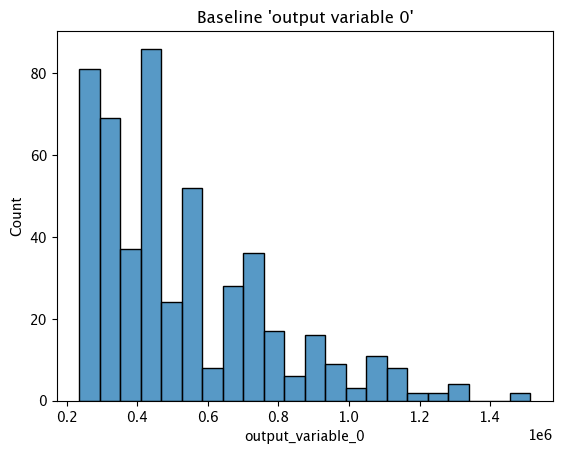

In [14]:
# get the assay builder histogram
assay_builder_from_dates.baseline_histogram()

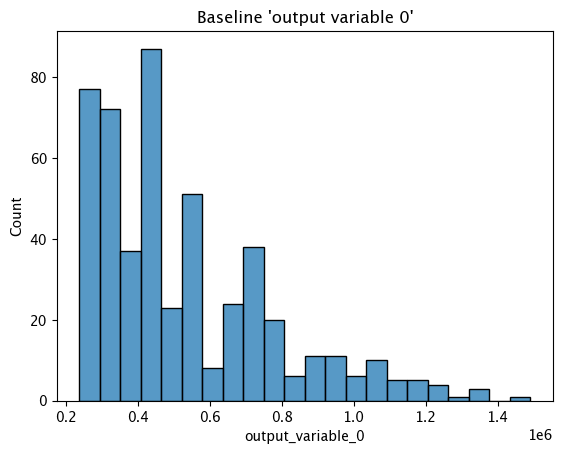

In [15]:
# get the assay builder histogram
assay_builder_from_numpy.baseline_histogram()

#### Get Assay Builder Baseline ECDF Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_ecdf`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a Empirical Cumulative Distribution Function (CDF) chart of the assay baseline generated from the provided parameters.

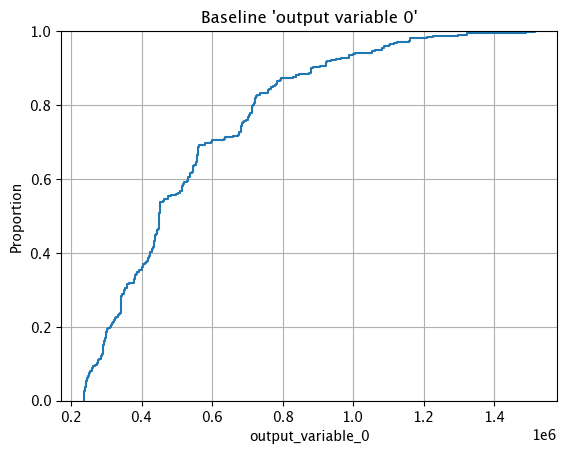

In [16]:
assay_builder_from_dates.baseline_ecdf()

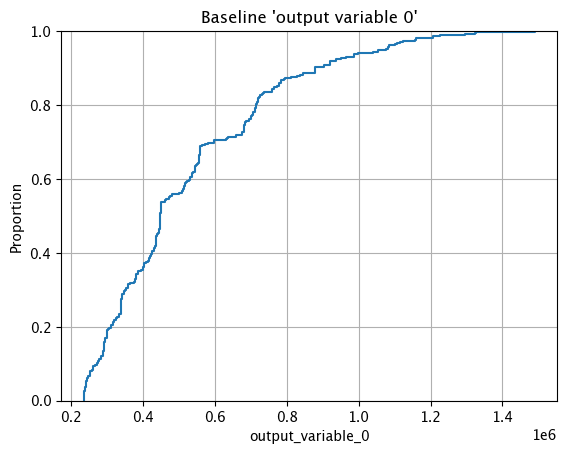

In [17]:
assay_builder_from_numpy.baseline_ecdf()

#### Get Assay Builder Baseline KDE Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_kde`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a Kernel Density Estimation (KDE) chart of the assay baseline generated from the provided parameters.

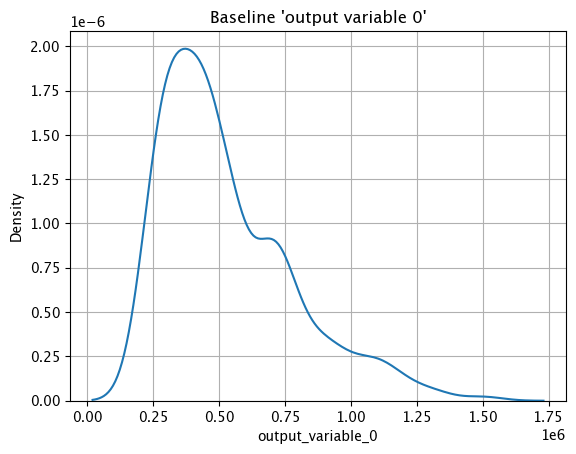

In [18]:
assay_builder_from_dates.baseline_kde()

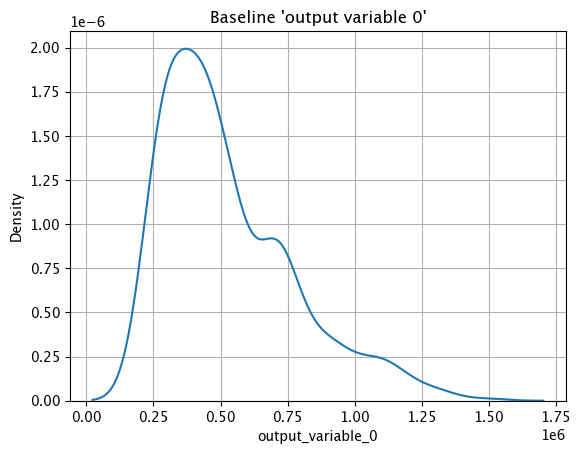

In [19]:
assay_builder_from_numpy.baseline_kde()

#### Get Assay Builder Baseline DataFrame

The method [`wallaroo.assay_config.AssayBuilder.baseline_ecdf`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a dataframe of the assay baseline generated from the provided parameters.  This includes:

* metadata:  The inference metadata with the model information, inference time, and other related factors.
* `in` data:  Each input field assigned with the label `in.{input field name}`.
* `out` data:  Each output field assigned with the label `out.{output field name}`

Note that for assays generated from numpy values, there is only the output variable based on the supplied baseline data.

In [24]:
# get the assay dataframe
assay_builder_from_dates.baseline_dataframe().loc[:, ['time', 'output_variable_0']]

,time,output_variable_0
0,1706726290673,1.514079e+06
1,1706726321539,5.534632e+05
2,1706726321539,7.064074e+05
3,1706726321539,3.586682e+05
4,1706726321539,9.216954e+05
...,...,...
496,1706726321539,8.738484e+05
497,1706726321539,5.810029e+05
498,1706726321539,1.085835e+06
499,1706726321539,3.342577e+05


In [22]:
# get the assay dataframe
assay_builder_from_numpy.baseline_dataframe()

,output_variable_0
0,553463.25
1,706407.40
2,358668.20
3,921695.40
4,759983.60
...,...
495,873848.44
496,581002.94
497,1085835.40
498,334257.70


### Assay Testing

Now we'll perform some inferences with a spread of values, then a larger set with a set of larger house values to trigger our assay alert.  We'll use our assay created from the numpy baseline values to demonstrate.

Because our assay windows are 1 minutes, we'll need to stagger our inference values to be set into the proper windows.  This will take about 2 minutes.

In [25]:
# Get a spread of house values

# Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

time.sleep(65)
inference_size = 1000

# And a spread of large house values

big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

mainpipeline.infer(big_houses)

time.sleep(65)

### Interactive Assay Runs

By default the assay builder creates an assay that runs a new analysis for every 24 hours starting at the end of the baseline period.  We can perform an interactive run to collect the data currently available and evaluate the details.

This requires two methods be used:

* `wallaroo.assay_config.add_run_until(run_until: datetime.datetime)`: Sets how long the assay should run to limit the number of analyses.  This is used to narrow down the number of records.  Typically the datetime is set to `datetime.now()` to run the assay until the current time.
* [`wallaroo.assay_config.AssayBuilder.window_builder.add_start`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_start): Sets the starting period for collecting data for the interactive run.
* `wallaroo.assay_config.interactive_run()`: Runs this assay interactively and returns a  [`wallaroo.assay.AssayAnalysisList`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList) object.  Each Assay Analysis contains the assay results per window. The assay is not saved to the Wallaroo database nor are analysis records saved to a Plateau topic. Useful for exploring pipeline inference data and experimenting with thresholds.

In [28]:
# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()
len(assay_analysis_from_dates)

2

### Assay Analysis List Data

Each `wallaroo.assay.AssayAnalysisList` element `wallaroo.assay.AssayAnalysis` contains the assay baseline, which is then displayed and compared against the assay window.

The `wallaroo.assay.AssayAnalysisList` provides a set of data analysis tools to retrieve aggregate information for all of the `AssayAnalysis` elements.

#### Get Assay Analysis List DataFrame

A DataFrame from `wallaroo.assay.AssayAnalysisList.to_dataframe()` shows the results generated from an Assay Interactive Run for each `AssayAnalysis` element in the `AssayAnalysisList`.  This DataFrame  contains the following fields:

| Field | Type | Description |
|---|---|---|
| assay_id | **Integer/None** | The assay id.  If this is from an interactive run and not an uploaded assay, the id is `None`.
| name | **String/None** | The name of the assay.  If this is from an interactive run and not an uploaded assay, the name is `None`.
| iopath | **String/None** | The iopath of the assay.  If this is from an interactive run and not an uploaded assay, the iopath is `None`.
| score | **Float** | The assay score. |
| start | **DateTime** | The DateTime start of the assay window.
| min | **Float** | The minimum value in the assay window.
| max  | **Float** | The maximum value in the assay window.
| mean | **Float** | The mean value in the assay window.
| median | **Float** | The median value in the assay window.
| std | **Float** | The standard deviation value in the assay window.
| warning_threshold | **Float/None** | The warning threshold of the assay window.
| alert_threshold | **Float/None** | The alert threshold of the assay window.
| status | **String** | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |

For this example, the assay analysis list DataFrame is listed from an interactive run.  For space reasons, only the `score`, `start`, `alert_threshold` and `status` are shown.

In [29]:
# get the dataframe from the interactive run
assay_analysis_from_dates.to_dataframe().loc[:, ['score', 'start', 'alert_threshold', 'status']]

,score,start,alert_threshold,status
0,0.000000,2024-01-31T18:38:10.607556+00:00,0.25,Ok
1,8.868532,2024-01-31T18:48:10.607556+00:00,0.25,Alert


#### Get Assay Analysis List Chart Scores

Assay chart scores show the assay scores for each assay result interval.  Values that are outside of the alert threshold are colored red, while scores within the alert threshold are green.

Assay chart scores are displayed with the method [`wallaroo.assay.AssayAnalysisList.chart_scores(title: Optional[str] = None)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList.chart_scores), with ability to display an optional title with the chart.

The following example shows retrieving the assay results and displaying the chart scores.

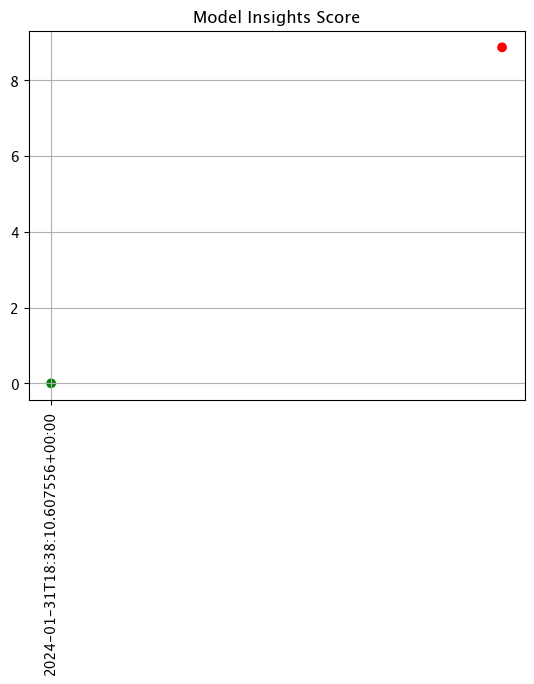

In [31]:
assay_analysis_from_dates.chart_scores()

#### Get Assay Analysis List Full DataFrame

[`wallaroo.assay.AssayAnalysisList.to_full_dataframe`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList.to_full_dataframe) returns a DataFrame with all values including inputs and outputs from the assay results.

The following example demonstrates displaying a summary of assay values as a DataFrame, and displaying a subset of those values.

In [36]:
assay_df = assay_analysis_from_dates.to_full_dataframe()

assay_df.loc[:, ['window_start', 'baseline_summary_count', 'status']]

,window_start,baseline_summary_count,status
0,2024-01-31T18:38:10.607556+00:00,501,Ok
1,2024-01-31T18:48:10.607556+00:00,501,Alert


### Assay Analysis Data

Data generated from either an interactive run or a scheduled assay run [`wallaroo.assay.AssayAnalysis`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysis) is displayed with the following methods.

From our interactive assay run, we will use the second element which contains our test inferences from earlier to show the `AssayAnalysis` for that assay window.

In [38]:
assay_analysis = assay_analysis_from_dates[1]

#### Get Assay Analysis Chart

The method `wallaroo.assay.AssayAnalysis.chart()` displays a baseline and the assay analysis window statistics chart with the following fields.

| Field | Type | Description |
|---|---|---|
| **baseline mean** | **Float** | The mean of the baseline values. |
| **window mean** | **Float** | The mean of the window values. |
| **baseline median** | **Float** | The median of the baseline values. |
| **window median** | **Float** | The median of the window values. |
| **bin_mode** | **String** | The binning mode used for the assay. |
| **aggregation** | **String** | The aggregation mode used for the assay. |
| **metric** | **String** | The metric mode used for the assay. |
| **weighted** | **Bool** | Whether the bins were manually weighted. |
| **score** | **Float** | The score from the assay window. |
| **scores** | **List(Float)** | The score from each assay window bin. |
| **index** | **Integer/None** | The window index.  Interactive assay runs are `None`. |

baseline mean = 529427.3240706088
window mean = 1865735.835875
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.868532111536265
scores = [0.0, 0.7174700740703411, 0.7361208231835864, 0.7174700740703411, 0.7081752864263594, 0.7174700740703411, 5.2718257797152965]
index = None


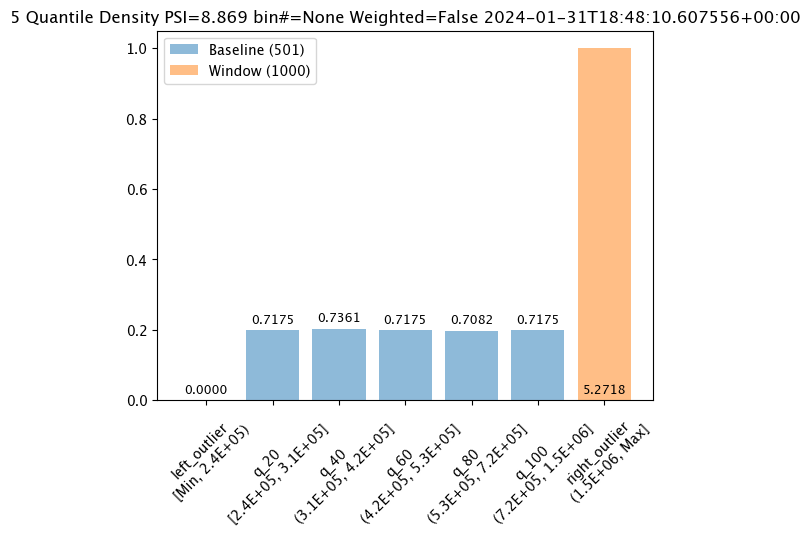

In [39]:
assay_analysis.chart()

#### Get Assay Analysis Baseline Stats

The method `wallaroo.assay.AssayAnalysis.baseline_stats()` returns a `pandas.core.frame.DataFrame` of the baseline stats.

The following example shows the baseline from the created assay.

In [40]:
# get the baseline stats
assay_analysis.baseline_stats()

,Baseline
count,501
min,236238.671875
max,1514079.375
mean,529427.324071
median,448627.8125
std,249672.942723
start,None
end,None


#### Get Assay Analysis Baseline Bins

The method `wallaroo.assay.AssayAnalysis.baseline_stats()` returns a `pandas.core.frame.DataFrame` of the baseline binning schemes.

The following example shows the baseline bins and binning schemes from the created assay.

In [42]:
# get the baseline bins
assay_analysis.baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,2.362387e+05,left_outlier,0.000000,Density
1,3.109929e+05,q_20,0.199601,Density
2,4.249666e+05,q_40,0.203593,Density
3,5.302889e+05,q_60,0.199601,Density
4,7.155301e+05,q_80,0.197605,Density
5,1.514079e+06,q_100,0.199601,Density
6,inf,right_outlier,0.000000,Density


#### Get Assay Analysis Compare Bins

The method `wallaroo.assay.AssayAnalysis.compare_bins()` returns a simple DataFrame to compare the bin/edge information of baseline and window.

In [44]:
# get the baseline bins
assay_bins = assay_analysis.compare_bins()
display(assay_bins.loc[:, assay_bins.columns!='w_aggregation'])

,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,2.362387e+05,left_outlier,0.000000,Density,2.362387e+05,left_outlier,0.0,0.000000
1,3.109929e+05,q_20,0.199601,Density,3.109929e+05,e_3.11e5,0.0,-0.199601
2,4.249666e+05,q_40,0.203593,Density,4.249666e+05,e_4.25e5,0.0,-0.203593
3,5.302889e+05,q_60,0.199601,Density,5.302889e+05,e_5.30e5,0.0,-0.199601
4,7.155301e+05,q_80,0.197605,Density,7.155301e+05,e_7.16e5,0.0,-0.197605
5,1.514079e+06,q_100,0.199601,Density,1.514079e+06,e_1.51e6,0.0,-0.199601
6,NaN,right_outlier,0.000000,Density,NaN,right_outlier,1.0,1.000000


#### Get Assay Analysis Compare Basic Stats

The method `wallaroo.assay.AssayAnalysis.compare_basic_stats` returns a DataFrame with basic stats for the baseline and window data.

In [45]:
assay_analysis.compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,501.0,1000.0,4.990000e+02,99.600798
min,236238.671875,1514079.375,1.277841e+06,540.910890
max,1514079.375,2016006.125,5.019268e+05,33.150623
mean,529427.324071,1865735.835875,1.336309e+06,252.406412
median,448627.8125,1946437.75,1.497810e+06,333.864708
std,249672.942723,171092.617396,-7.858033e+04,-31.473304
start,None,2024-01-31T18:48:10.607556+00:00,NaN,NaN
end,None,2024-01-31T18:49:10.607556+00:00,NaN,NaN


### Upload Assay

With the assay created and fully tested, we will upload it to the Wallaroo instance.  This will make it available for future demonstrations and visible through the Wallaroo UI.

In [46]:
assay_builder_from_numpy.upload()

1

The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.

![Sample assay in the UI](images/housepricesaga-sample-assay.png)

### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [47]:
mainpipeline.undeploy()

name,assay-demonstration-tutorial
created,2024-01-31 18:37:52.760861+00:00
last_updated,2024-01-31 18:37:53.486139+00:00
deployed,False
arch,None
tags,
versions,"53ad0c4c-456f-4171-97e7-22fa4a3e950c, bb6c24d3-a6b7-42b4-a01f-f7b21cec6770"
steps,housepricesagacontrol
published,False
